In [36]:
import copy
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster, 
    RecursiveRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
# from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss, MASE, mase_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

# Load exchange rates data (ECB)

In [2]:
from datetime import date
import io
import requests
import zipfile

EXCHANGE_RATES_URL = 'http://www.ecb.int/stats/eurofxref/eurofxref-hist.zip'

def request_exchange_rates():
    r = requests.get(url=EXCHANGE_RATES_URL, stream=True)
    zip_file = zipfile.ZipFile(io.BytesIO(r.content))
    df = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
    return df


def get_currency_exchange_rate(currencies: list):
    exchange_rates = request_exchange_rates()

    exchange_rates['Date'] = pd.to_datetime(exchange_rates['Date'], infer_datetime_format=True)
    exchange_rates['Day'] = exchange_rates['Date'].dt.day
    exchange_rates['Month'] = exchange_rates['Date'].dt.month
    exchange_rates['Year'] = exchange_rates['Date'].dt.year

    exchange_rates.sort_values(by=['Year', 'Month', 'Day'], inplace=True)
    exchange_rates.set_index('Date', inplace=True)
    
    indexed_df = pd.DataFrame()
    indexed_df['Date'] = pd.date_range(exchange_rates.index[0], exchange_rates.index[-1], freq='1H')
    indexed_df.set_index('Date')
    
    exchange_rates = pd.merge(exchange_rates, indexed_df, how='left', left_index=True,  right_index=True)
    exchange_rates.fillna(method='ffill', inplace=True)
    exchange_rates.fillna(method='bfill', inplace=True)

    exchange_rates['EUR'] = 1
    assert set(currencies).issubset(set(exchange_rates.columns)), 'Unknown currency'
    keep_columns = list(currencies)
    exchange_rates = exchange_rates[keep_columns]
    return exchange_rates
    
    
exchange_rates = get_currency_exchange_rate(currencies=['PLN'])
exchange_rates.head()

,PLN
Date,
1999-01-04 00:00:00,4.0712
1999-01-05 00:00:00,4.0245
1999-01-06 00:00:00,4.0065
1999-01-07 00:00:00,4.0165
1999-01-08 00:00:00,4.0363


In [12]:
exchange_rates.index = pd.to_datetime(exchange_rates.index)
exchange_rates = exchange_rates.resample('H').ffill()

exchange_rates.head()

,PLN
Date,
1999-01-04 00:00:00,4.0712
1999-01-04 01:00:00,4.0712
1999-01-04 02:00:00,4.0712
1999-01-04 03:00:00,4.0712
1999-01-04 04:00:00,4.0712


# Load external predictions

In [13]:
external_predictions = pd.read_csv("historical_forecasts.csv", sep=";")

external_predictions.head()

,delivery_date,forecast_n-1_9:00
0,2019-09-02 00:00:00,"52,89"
1,2019-09-02 01:00:00,"51,43"
2,2019-09-02 02:00:00,"50,57"
3,2019-09-02 03:00:00,"50,37"
4,2019-09-02 04:00:00,"50,28"


In [14]:
external_predictions = external_predictions.rename(columns={'delivery_date': 'date', 'forecast_n-1_9:00': 'forecast'})
external_predictions['date'] = pd.to_datetime(external_predictions['date'])
external_predictions['forecast'] = external_predictions['forecast'].str.replace(',', '.').astype('float64')
external_predictions = external_predictions.set_index('date').sort_index()

external_predictions.head()

,forecast
date,
2019-09-02 00:00:00,52.89
2019-09-02 01:00:00,51.43
2019-09-02 02:00:00,50.57
2019-09-02 03:00:00,50.37
2019-09-02 04:00:00,50.28


In [15]:
external_predictions = external_predictions.merge(exchange_rates, how='left', left_index=True, right_index=True)

external_predictions.head()

,forecast,PLN
2019-09-02 00:00:00,52.89,4.3691
2019-09-02 01:00:00,51.43,4.3691
2019-09-02 02:00:00,50.57,4.3691
2019-09-02 03:00:00,50.37,4.3691
2019-09-02 04:00:00,50.28,4.3691


In [21]:
external_predictions['forecast_PLN'] = external_predictions['forecast'] * external_predictions['PLN']
external_predictions = external_predictions.drop(['forecast', 'PLN'], axis=1)

external_predictions.head()

,forecast_PLN
2019-09-02 00:00:00,231.081699
2019-09-02 01:00:00,224.702813
2019-09-02 02:00:00,220.945387
2019-09-02 03:00:00,220.071567
2019-09-02 04:00:00,219.678348


In [49]:
external_predictions.tail(30)

,forecast_PLN
2021-03-31 18:00:00,307.789944
2021-03-31 19:00:00,319.742500
2021-03-31 20:00:00,313.045348
2021-03-31 21:00:00,307.417880
2021-03-31 22:00:00,297.837232
2021-03-31 23:00:00,274.211168
2021-04-01 00:00:00,239.201910
2021-04-01 01:00:00,NaN
2021-04-01 02:00:00,NaN
2021-04-01 03:00:00,NaN


In [88]:
external_predictions = external_predictions[~external_predictions['forecast_PLN'].isnull()]
external_predictions = external_predictions.iloc[~external_predictions.index.duplicated(keep="first")]

# Load original data - realised prices

In [90]:
raw_data = pd.read_csv('prices.csv')
raw_data.head()

,delivery_start_utc,delivery_end_utc,price
0,21.03.2021 22:00:00,21.03.2021 23:00:00,244.29
1,21.03.2021 21:00:00,21.03.2021 22:00:00,260.00
2,21.03.2021 20:00:00,21.03.2021 21:00:00,265.00
3,21.03.2021 19:00:00,21.03.2021 20:00:00,286.10
4,21.03.2021 18:00:00,21.03.2021 19:00:00,295.79


In [91]:
dates = pd.to_datetime(raw_data['delivery_start_utc'], format='%d.%m.%Y %H:%M:%S')
data = raw_data[['price']]
data.index = dates
data = data.sort_index()
data.index.freq = 'H'

data.head()

,price
delivery_start_utc,
2010-01-01 00:00:00,129.30
2010-01-01 01:00:00,110.17
2010-01-01 02:00:00,104.46
2010-01-01 03:00:00,105.00
2010-01-01 04:00:00,105.01


In [92]:
index_copy = data.index
data = data.merge(external_predictions, how='left', right_index=True, left_index=True)
data.index = index_copy

data.head()

,price,forecast_PLN
delivery_start_utc,,
2010-01-01 00:00:00,129.30,NaN
2010-01-01 01:00:00,110.17,NaN
2010-01-01 02:00:00,104.46,NaN
2010-01-01 03:00:00,105.00,NaN
2010-01-01 04:00:00,105.01,NaN


In [93]:
data.tail()

,price,forecast_PLN
delivery_start_utc,,
2021-03-21 18:00:00,295.79,243.2430
2021-03-21 19:00:00,286.10,266.2044
2021-03-21 20:00:00,265.00,264.1716
2021-03-21 21:00:00,260.00,247.3548
2021-03-21 22:00:00,244.29,237.2832


# Explonatory data analysis

In [96]:
y = data['price']

y.head()

delivery_start_utc
2010-01-01 00:00:00    129.30
2010-01-01 01:00:00    110.17
2010-01-01 02:00:00    104.46
2010-01-01 03:00:00    105.00
2010-01-01 04:00:00    105.01
Freq: H, Name: price, dtype: float64

In [97]:
y.tail()

delivery_start_utc
2021-03-21 18:00:00    295.79
2021-03-21 19:00:00    286.10
2021-03-21 20:00:00    265.00
2021-03-21 21:00:00    260.00
2021-03-21 22:00:00    244.29
Freq: H, Name: price, dtype: float64

In [98]:
len(y)

98351

In [99]:
y.describe()

count    98351.000000
mean       186.746688
std         62.415608
min         31.000000
25%        146.840000
50%        180.000000
75%        211.330000
max       1405.440000
Name: price, dtype: float64

<AxesSubplot:>

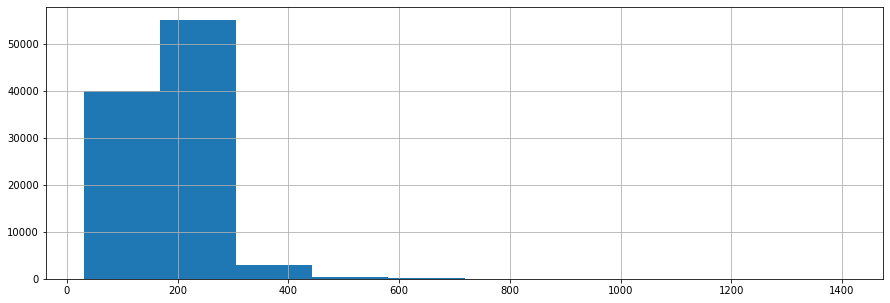

In [100]:
y.hist()

<AxesSubplot:>

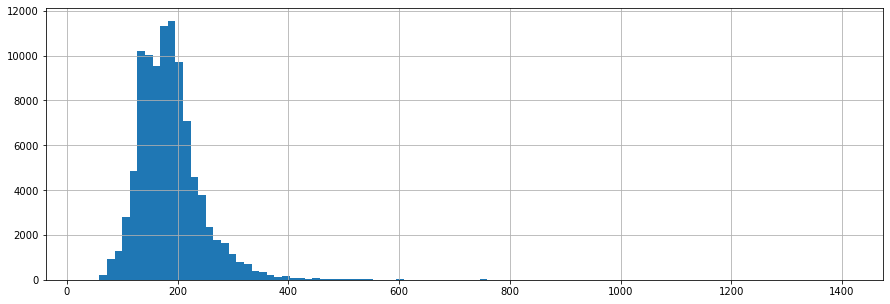

In [101]:
y.hist(bins=100)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

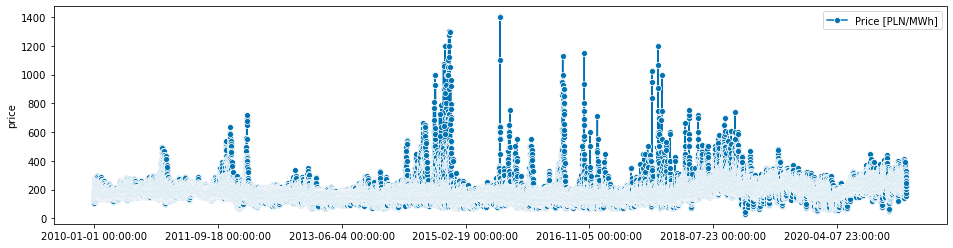

In [41]:
plot_series(y, labels=['Price [PLN/MWh]'])

# Train-test time series split

In [102]:
from datetime import datetime, timedelta

START_TRAIN_DATE = datetime(2020, 1, 1)
END_TRAIN_DATE = datetime(2020, 12, 31, 23, 0, 0)
START_TEST_DATE = END_TRAIN_DATE + timedelta(hours=1)
END_TEST_DATE = datetime(2021, 3, 20, 23, 0, 0)

# y_train, y_test = temporal_train_test_split(y, test_size=N_HOURS*N_DAYS)
y_train, y_test = y[START_TRAIN_DATE:END_TRAIN_DATE].copy(), y[START_TEST_DATE:END_TEST_DATE].copy()
print(f'y_train shape: {y_train.shape[0]}, y_test_shape: {y_test.shape[0]} ')

y_train shape: 8784, y_test_shape: 1896 


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

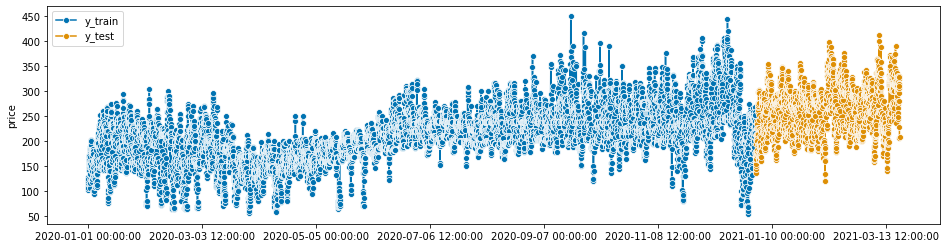

In [103]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

In [127]:
y_ext_train = data['forecast_PLN'].loc[START_TRAIN_DATE:END_TRAIN_DATE]
y_ext_test = data['forecast_PLN'].loc[START_TEST_DATE:END_TEST_DATE]

## Train/test subsample

In [108]:
START_TRAIN_SAMPLE_DATE = datetime(2020, 10, 31) 
END_TRAIN_SAMPLE_DATE = datetime(2020, 12, 31, 23, 0, 0)
START_TEST_SAMPLE_DATE = datetime(2021, 1, 1)
END_TEST_SAMPLE_DATE = datetime(2021, 1, 31, 23, 0, 0)

y_train_sample = y_train.loc[START_TRAIN_SAMPLE_DATE:END_TRAIN_SAMPLE_DATE]
y_test_sample = y_test.loc[START_TEST_SAMPLE_DATE:END_TEST_SAMPLE_DATE]

y_pred_train_sample = data['forecast_PLN'].loc[START_TRAIN_SAMPLE_DATE:END_TRAIN_SAMPLE_DATE]
y_pred_test_sample = data['forecast_PLN'].loc[START_TEST_SAMPLE_DATE:END_TEST_SAMPLE_DATE]

In [109]:
train_start_index = y_train_sample.index[0]
train_end_index = y_train_sample.index[-1]
test_start_index = y_test_sample.index[0]
test_end_index = y_test_sample.index[-1]

print(f'Train sample: from {train_start_index} to {train_end_index}')
print(f'Test sample: from {test_start_index} to {test_end_index}')

Train sample: from 2020-10-31 00:00:00 to 2020-12-31 23:00:00
Test sample: from 2021-01-01 00:00:00 to 2021-01-31 23:00:00


Naive forecaster RMSE: 88.68550698882873. External predictions RMSE: 25.32533193094695


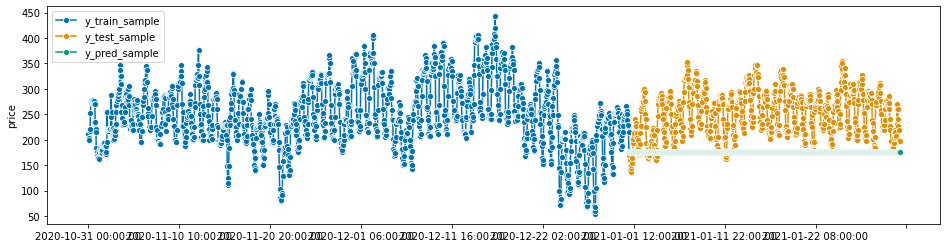

In [116]:
naive_forecaster = NaiveForecaster(strategy='last')
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

Naive forecaster RMSE: 39.88389201087933. External predictions RMSE: 25.32533193094695


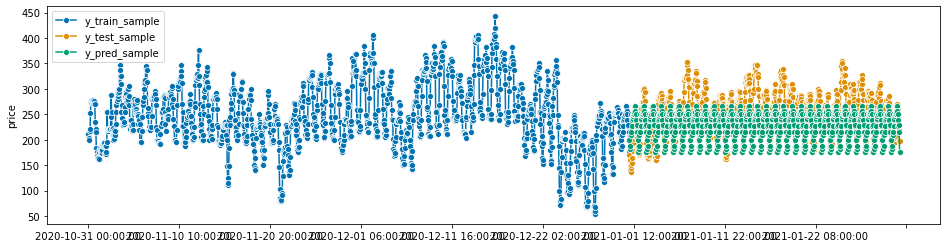

In [122]:
naive_forecaster = NaiveForecaster(strategy='last', sp=24)
naive_forecaster.fit(y_train_sample)
fh_index = y_test_sample.index

fh = ForecastingHorizon(fh_index, is_relative=False)
y_pred_sample = naive_forecaster.predict(fh)
plot_series(y_train_sample, y_test_sample, y_pred_sample, 
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])

rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

In [123]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

In [124]:
fh_index = y_test_sample.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    forecaster.fit(y_train_sample)
    y_pred_sample = forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
    rmse_metrics[naive_forecaster_name] = rmse

In [125]:
rmse_metrics

{'sp1_last': 88.68550698882873,
 'sp1_mean_1': 50.62915178387905,
 'sp1_mean_2': 52.017785057651075,
 'sp1_mean_3': 54.78151988429431,
 'sp1_mean_4': 58.19422757263181,
 'sp1_mean_5': 69.371234931098,
 'sp1_mean_6': 73.04884581473956,
 'sp1_mean_7': 74.58582529732865,
 'sp1_mean_all': 45.26141107061557,
 'sp24_last': 39.88389201087933,
 'sp24_mean_1': 39.88389201087933,
 'sp24_mean_2': 40.837606529477846,
 'sp24_mean_3': 44.03160387833455,
 'sp24_mean_4': 49.6825918827663,
 'sp24_mean_5': 62.033832726303906,
 'sp24_mean_6': 65.84046718533439,
 'sp24_mean_7': 67.73135644737155,
 'sp24_mean_all': 30.864759327466633}

Naive forecaster RMSE: 30.864759327466633. External predictions RMSE: 25.32533193094695


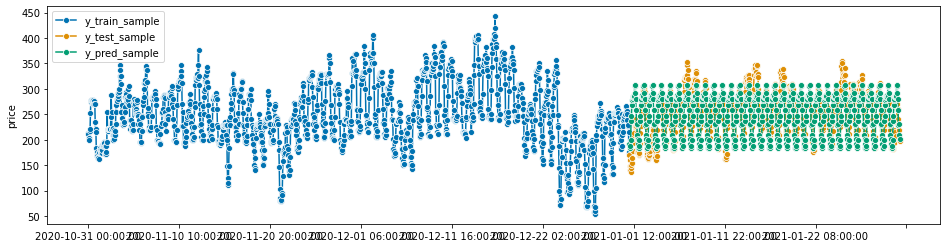

In [126]:
best_forecaster_name = max(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_forecaster.fit(y_train_sample)
y_pred_sample = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_sample))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test_sample, y_pred=y_pred_test_sample))
plot_series(y_train_sample, y_test_sample, y_pred_sample,
            labels=['y_train_sample', 'y_test_sample', 'y_pred_sample'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')

## Train/test full sample

In [132]:
naive_forecasters = {
    'sp1_last': NaiveForecaster(strategy='last', sp=1),
    'sp1_mean_1': NaiveForecaster(strategy='mean', sp=1, window_length=24),
    'sp1_mean_2': NaiveForecaster(strategy='mean', sp=1, window_length=48),
    'sp1_mean_3': NaiveForecaster(strategy='mean', sp=1, window_length=72),
    'sp1_mean_4': NaiveForecaster(strategy='mean', sp=1, window_length=96),
    'sp1_mean_5': NaiveForecaster(strategy='mean', sp=1, window_length=120),
    'sp1_mean_6': NaiveForecaster(strategy='mean', sp=1, window_length=144),
    'sp1_mean_7': NaiveForecaster(strategy='mean', sp=1, window_length=168),
    'sp1_mean_all': NaiveForecaster(strategy='mean', sp=1, window_length=None),
    'sp24_last': NaiveForecaster(strategy='last', sp=24),
    'sp24_mean_1': NaiveForecaster(strategy='mean', sp=24, window_length=24),
    'sp24_mean_2': NaiveForecaster(strategy='mean', sp=24, window_length=48),
    'sp24_mean_3': NaiveForecaster(strategy='mean', sp=24, window_length=72),
    'sp24_mean_4': NaiveForecaster(strategy='mean', sp=24, window_length=96),
    'sp24_mean_5': NaiveForecaster(strategy='mean', sp=24, window_length=120),
    'sp24_mean_6': NaiveForecaster(strategy='mean', sp=24, window_length=144),
    'sp24_mean_7': NaiveForecaster(strategy='mean', sp=24, window_length=168),
    'sp24_mean_all': NaiveForecaster(strategy='mean', sp=24, window_length=None),
}

In [133]:
fh_index = y_test.index
fh = ForecastingHorizon(fh_index, is_relative=False)
rmse_metrics = dict()
for naive_forecaster_name, naive_forecaster in naive_forecasters.items():
    forecaster = copy.deepcopy(naive_forecaster)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    rmse_metrics[naive_forecaster_name] = rmse

In [134]:
rmse_metrics

{'sp1_last': 98.21779942582012,
 'sp1_mean_1': 58.13418667059755,
 'sp1_mean_2': 59.791323064975906,
 'sp1_mean_3': 62.96040471618108,
 'sp1_mean_4': 66.72654127264163,
 'sp1_mean_5': 78.5268038009509,
 'sp1_mean_6': 82.31754234577284,
 'sp1_mean_7': 83.89391930787987,
 'sp1_mean_all': 71.49030224896335,
 'sp24_last': 50.65415925302483,
 'sp24_mean_1': 50.65415925302483,
 'sp24_mean_2': 52.061364717311264,
 'sp24_mean_3': 55.62363922259745,
 'sp24_mean_4': 61.44247035633353,
 'sp24_mean_5': 74.03458564484153,
 'sp24_mean_6': 77.78061481591779,
 'sp24_mean_7': 79.74104178475055,
 'sp24_mean_all': 64.61722656126032}

Naive forecaster RMSE: 64.61722656126032. External predictions RMSE: 24.736368591793646


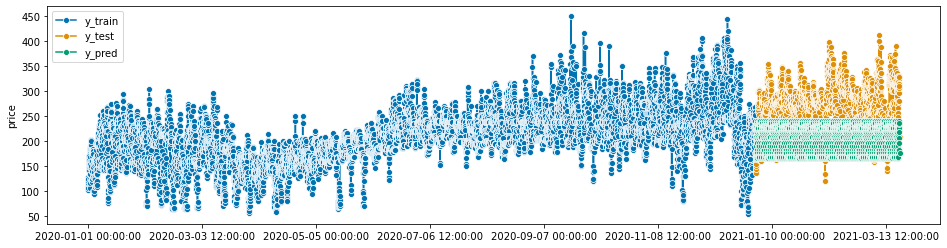

In [135]:
best_forecaster_name = max(rmse_metrics, key=rmse_metrics.get)
best_forecaster = naive_forecasters.get(best_forecaster_name)
best_forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
rmse_test = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
rmse_ext = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_ext_test))
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(f'Naive forecaster RMSE: {rmse_test}. External predictions RMSE: {rmse_ext}')